In [11]:
from data_prep import load_prices
from feature_engineering import build_features, make_nextday_target, add_lags
from model_arimax import walk_forward_arimax, analyze_residuals
from evaluation_visualization import  plot_detailed_strategy_window,plot_strategy_heatmap,plot_rolling_performance_metrics,enhanced_plot_cum_pnl,run_cfg,print_overall_metrics,plot_hitrate_timeline,plot_cum_pnl
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
from pathlib import Path
from datetime import datetime
from types import SimpleNamespace
import json


c:\Workplace\ML_finance\Git_Project_Finance\Walkforward-Arimax\data_prep.py:15: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  ts = pd.to_datetime(d, dayfirst=dayfirst, errors="raise")
c:\Workplace\ML_finance\Git_Project_Finance\Walkforward-Arimax\data_prep.py:15: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  ts = pd.to_datetime(d, dayfirst=dayfirst, errors="raise")


=== CFG1 (1-day) — Top by RMSE ===
1-day +mkt_ret_l1,macd_hist_l1 [zscore]: RMSE=0.034658  MAE=0.025535  Hit=0.507  Windows=895
1-day +mkt_ret_l1,macd_hist_l1 [robust]: RMSE=0.034668  MAE=0.025561  Hit=0.505  Windows=895
1-day +mkt_ret_l1,macd_hist_l1,macd_hist_l2,vol_z_l1 [zscore]: RMSE=0.034686  MAE=0.025646  Hit=0.489  Windows=894


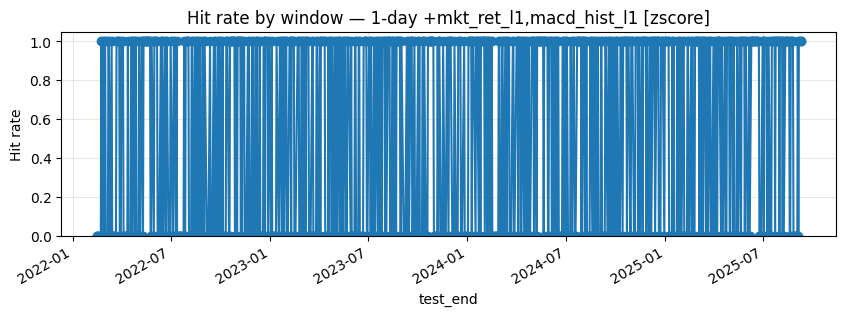

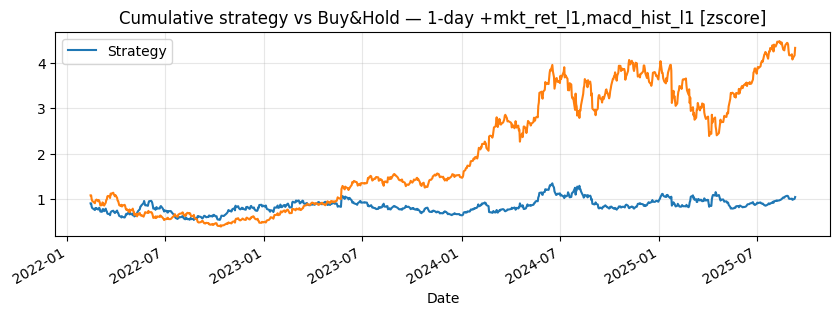

=== Overall metrics ===
1-day  [zscore]: RMSE=0.034658  MAE=0.025535  Hit=0.507  Windows=895
5-day  [zscore]: RMSE=0.034577  MAE=0.025469  Hit=0.521  Windows=179
20-day  [zscore]: RMSE=0.034825  MAE=0.025694  Hit=0.524  Windows=44


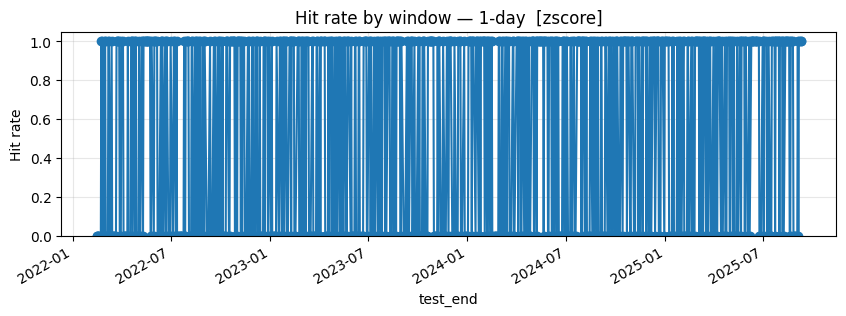

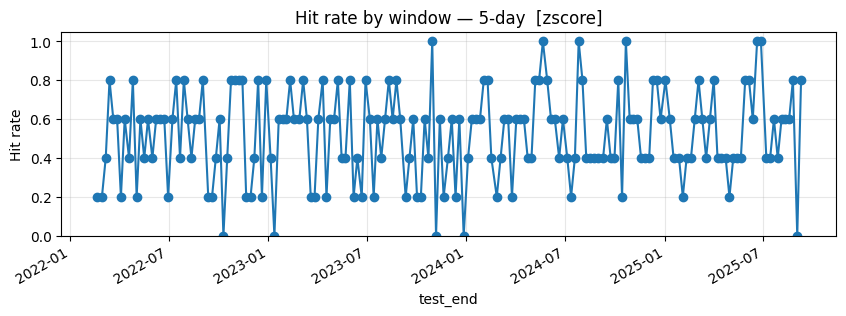

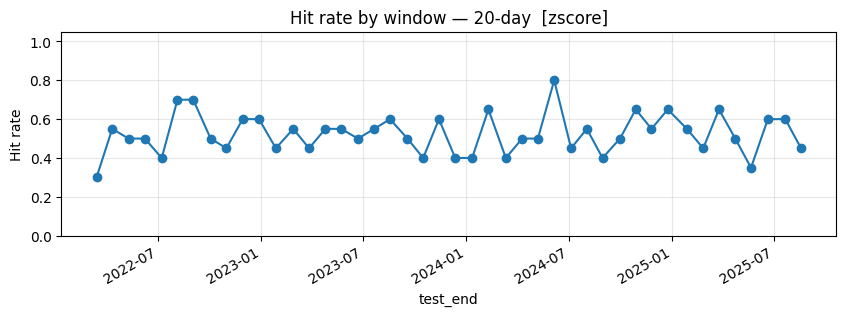

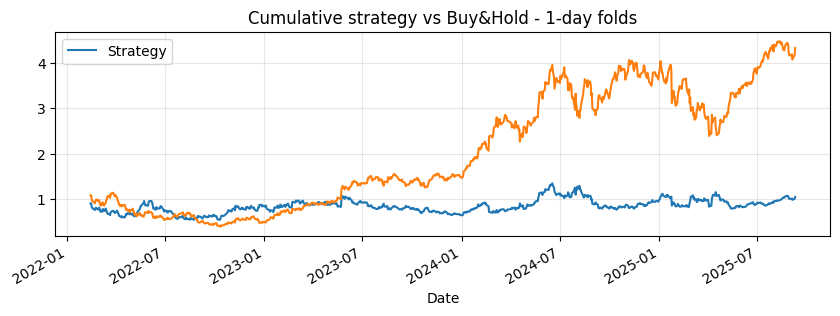

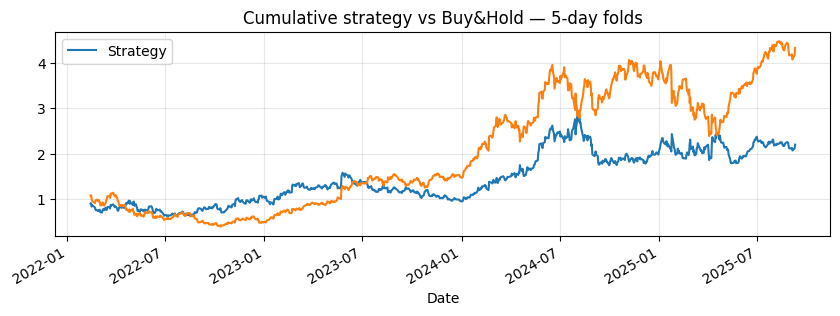

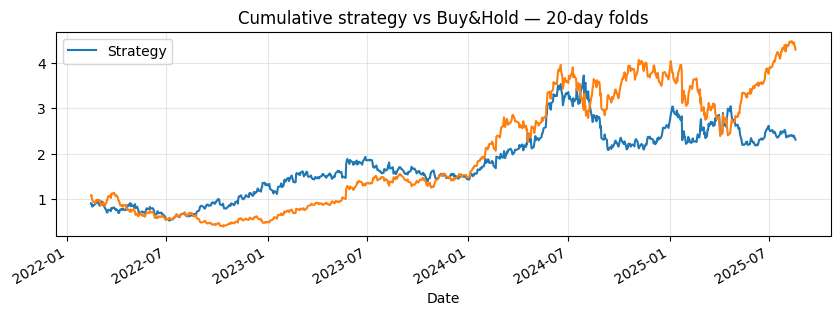

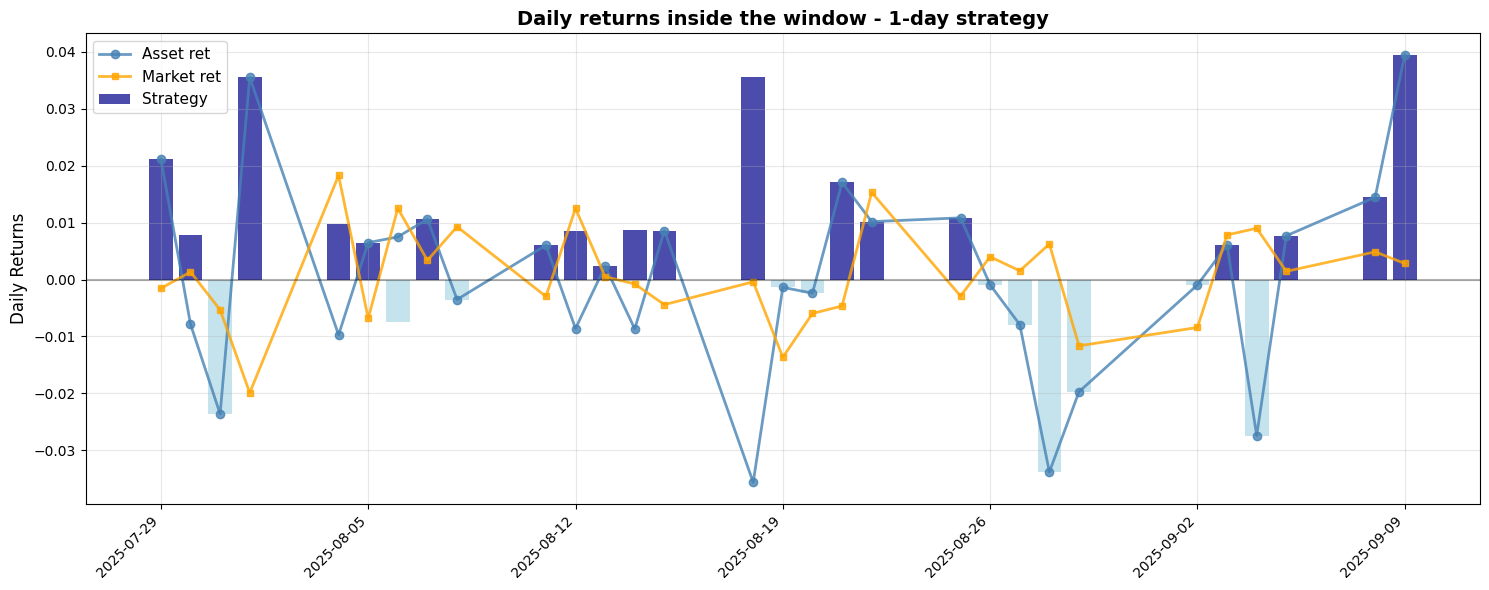

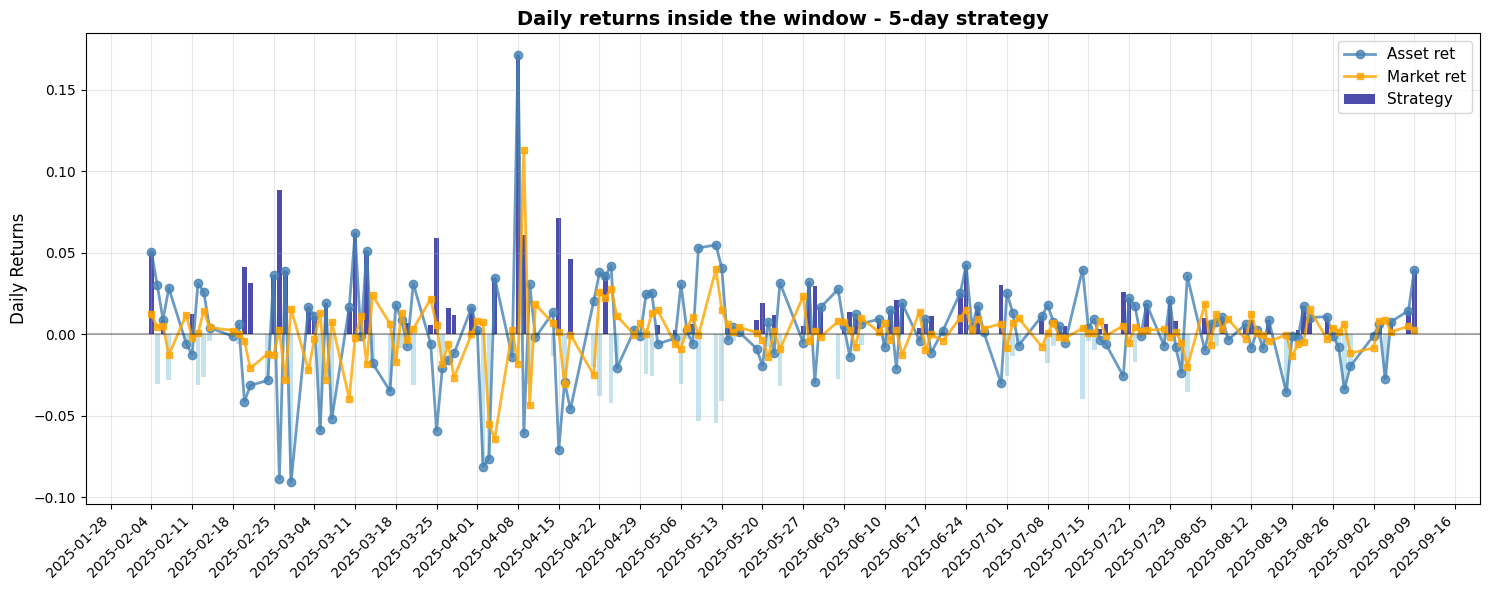

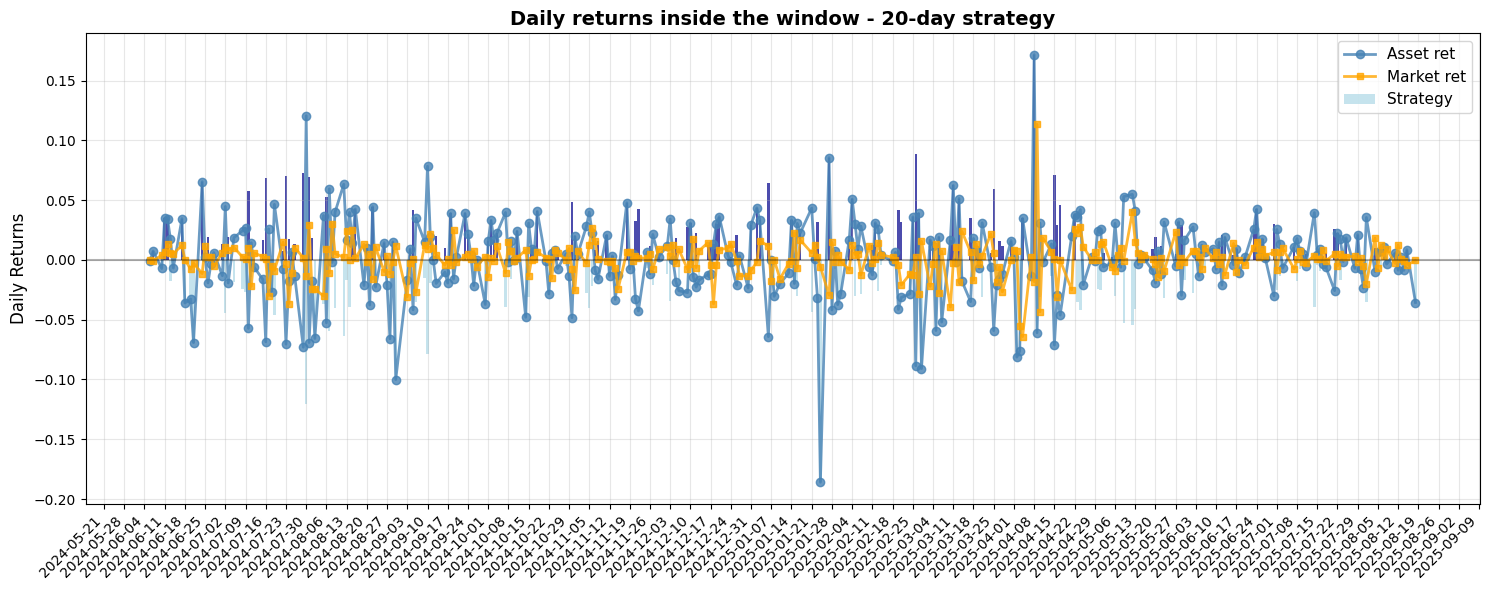

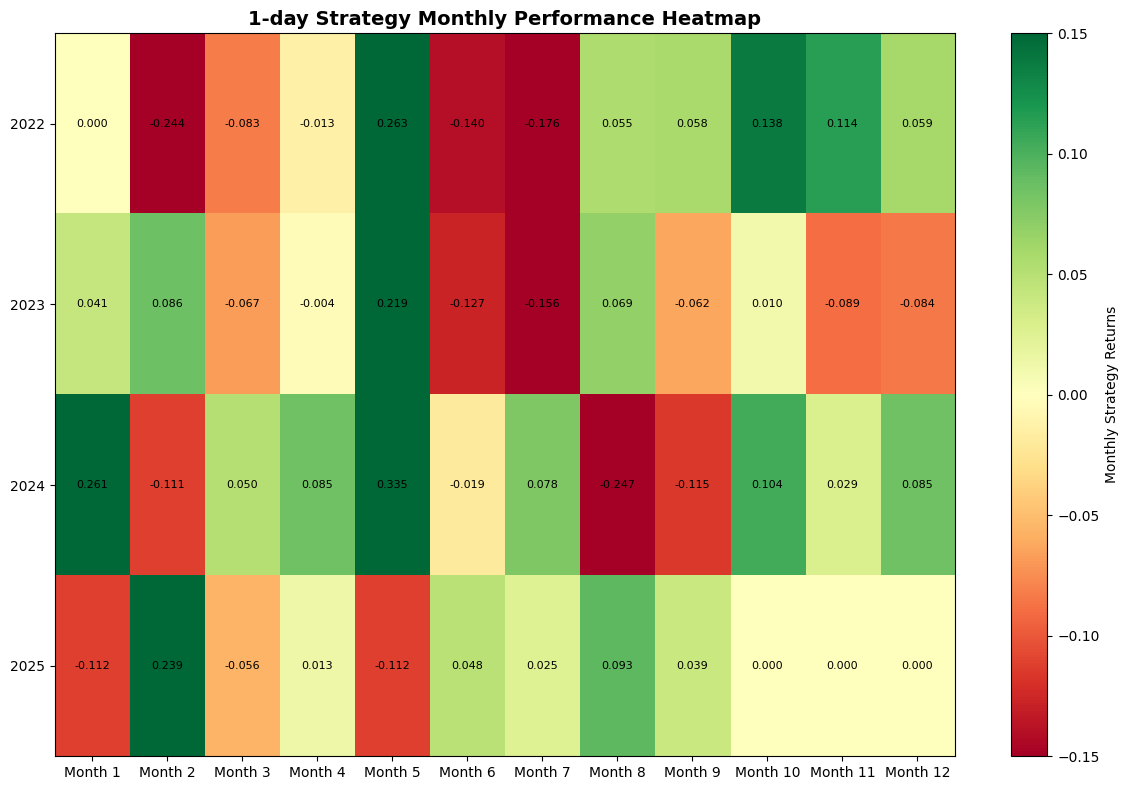

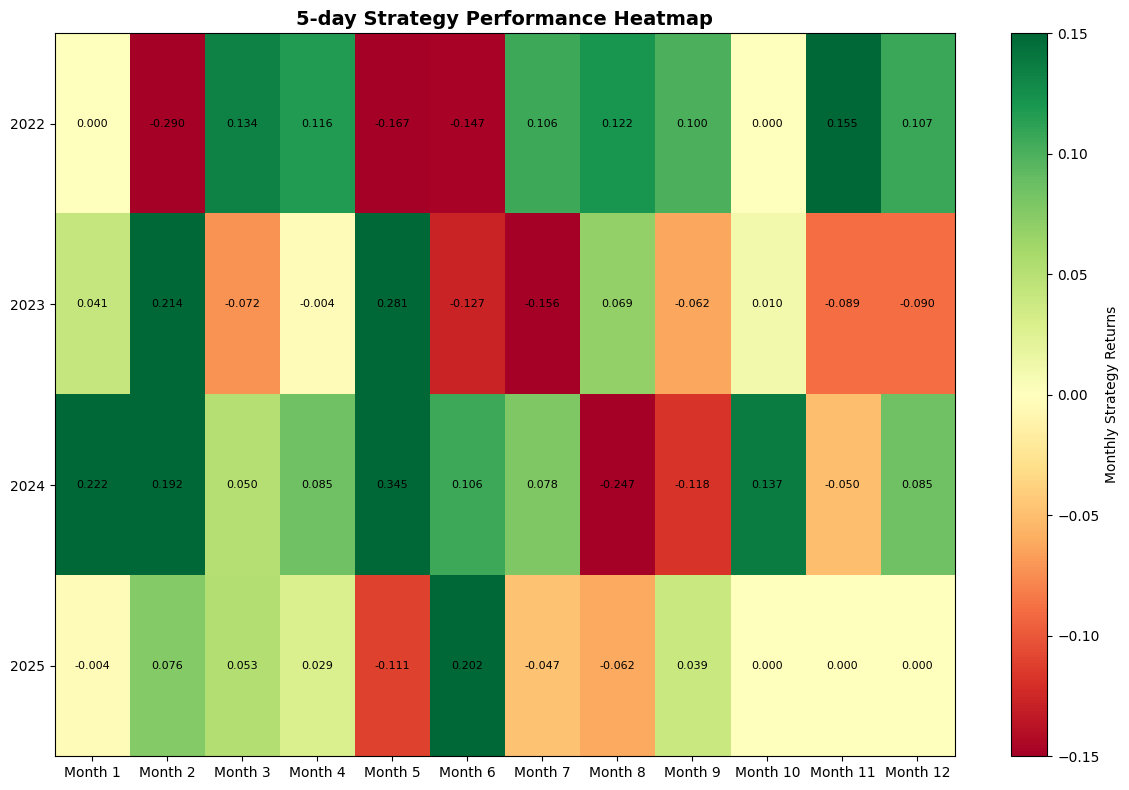

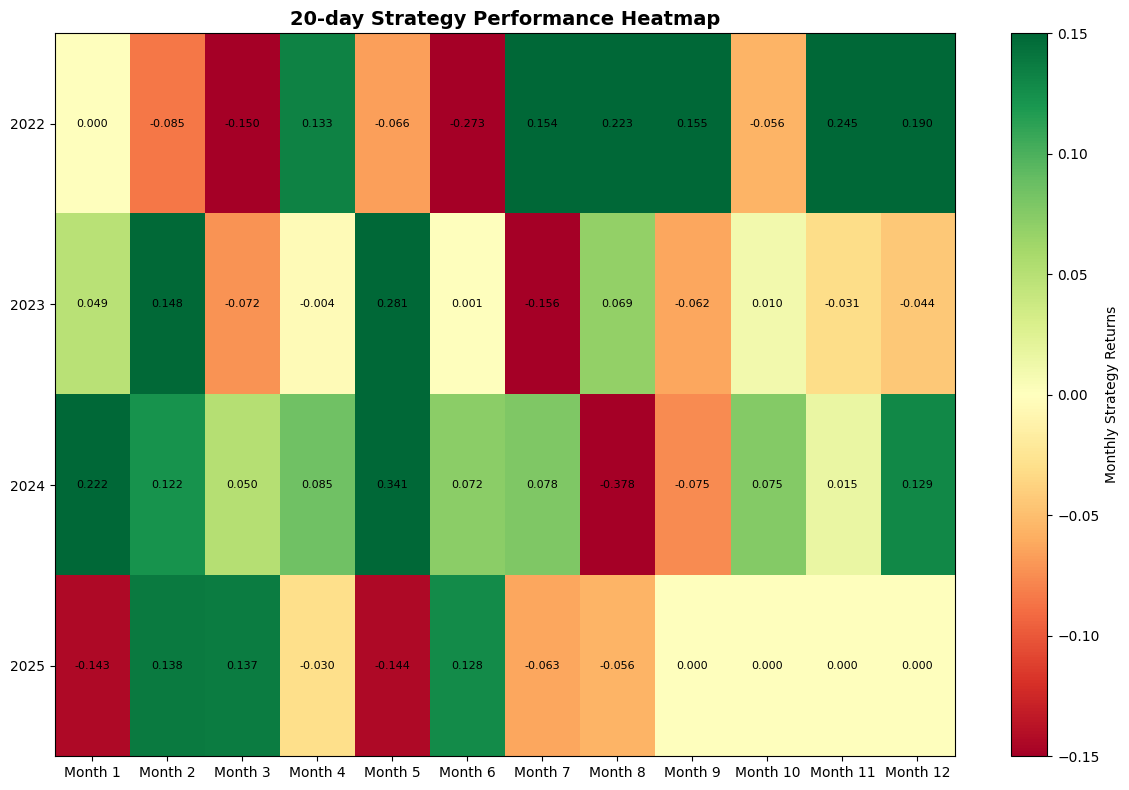

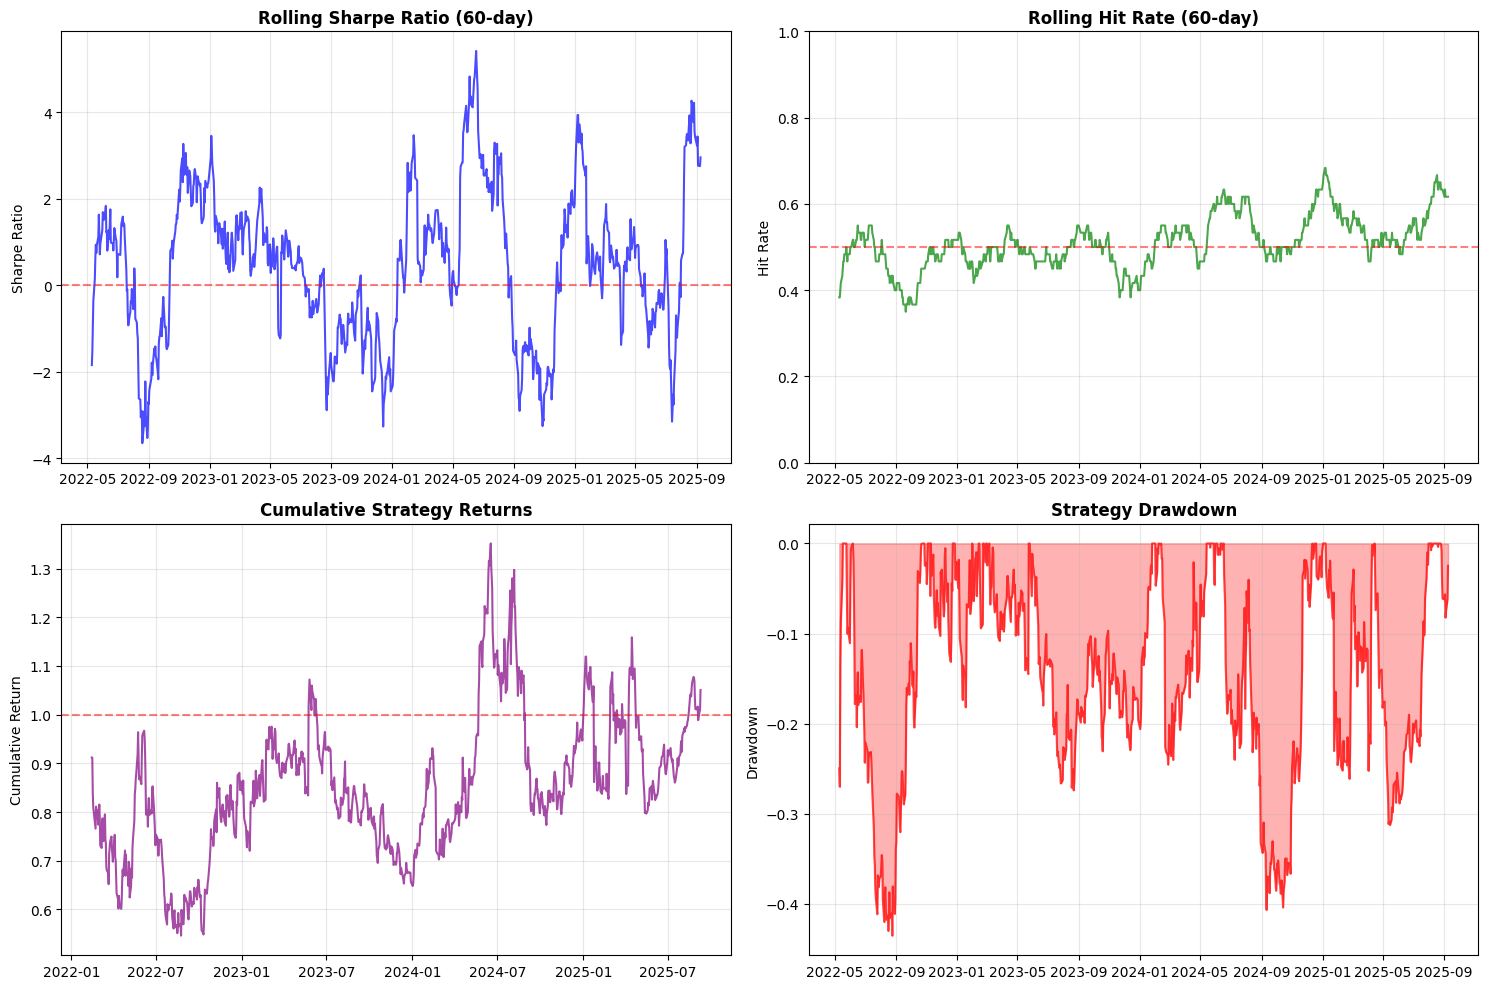

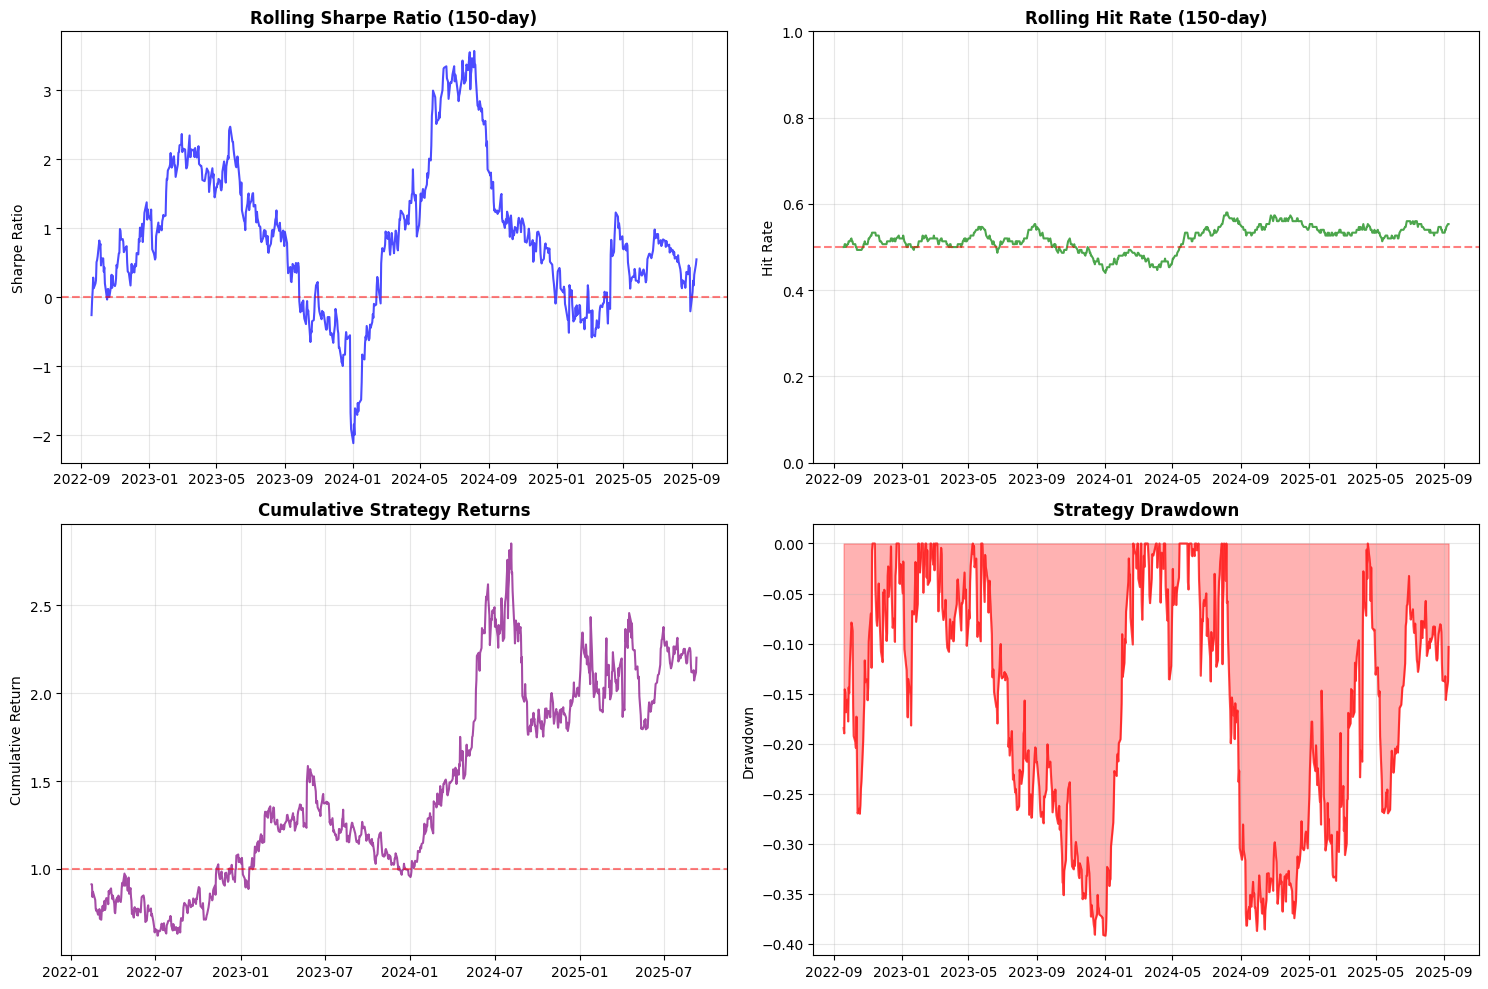

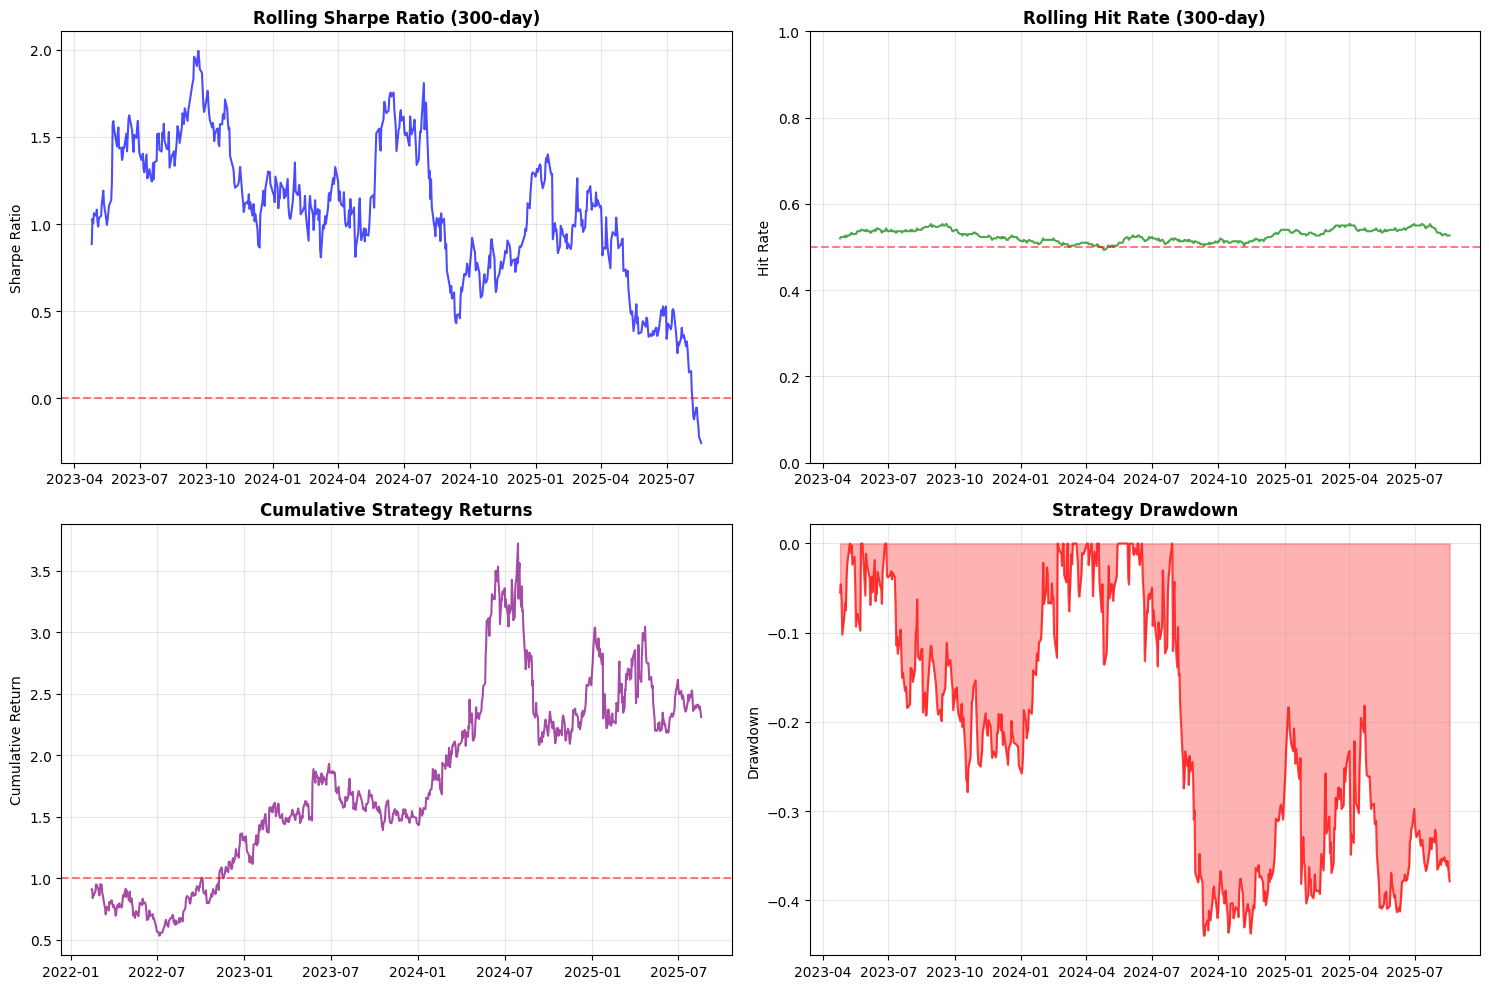

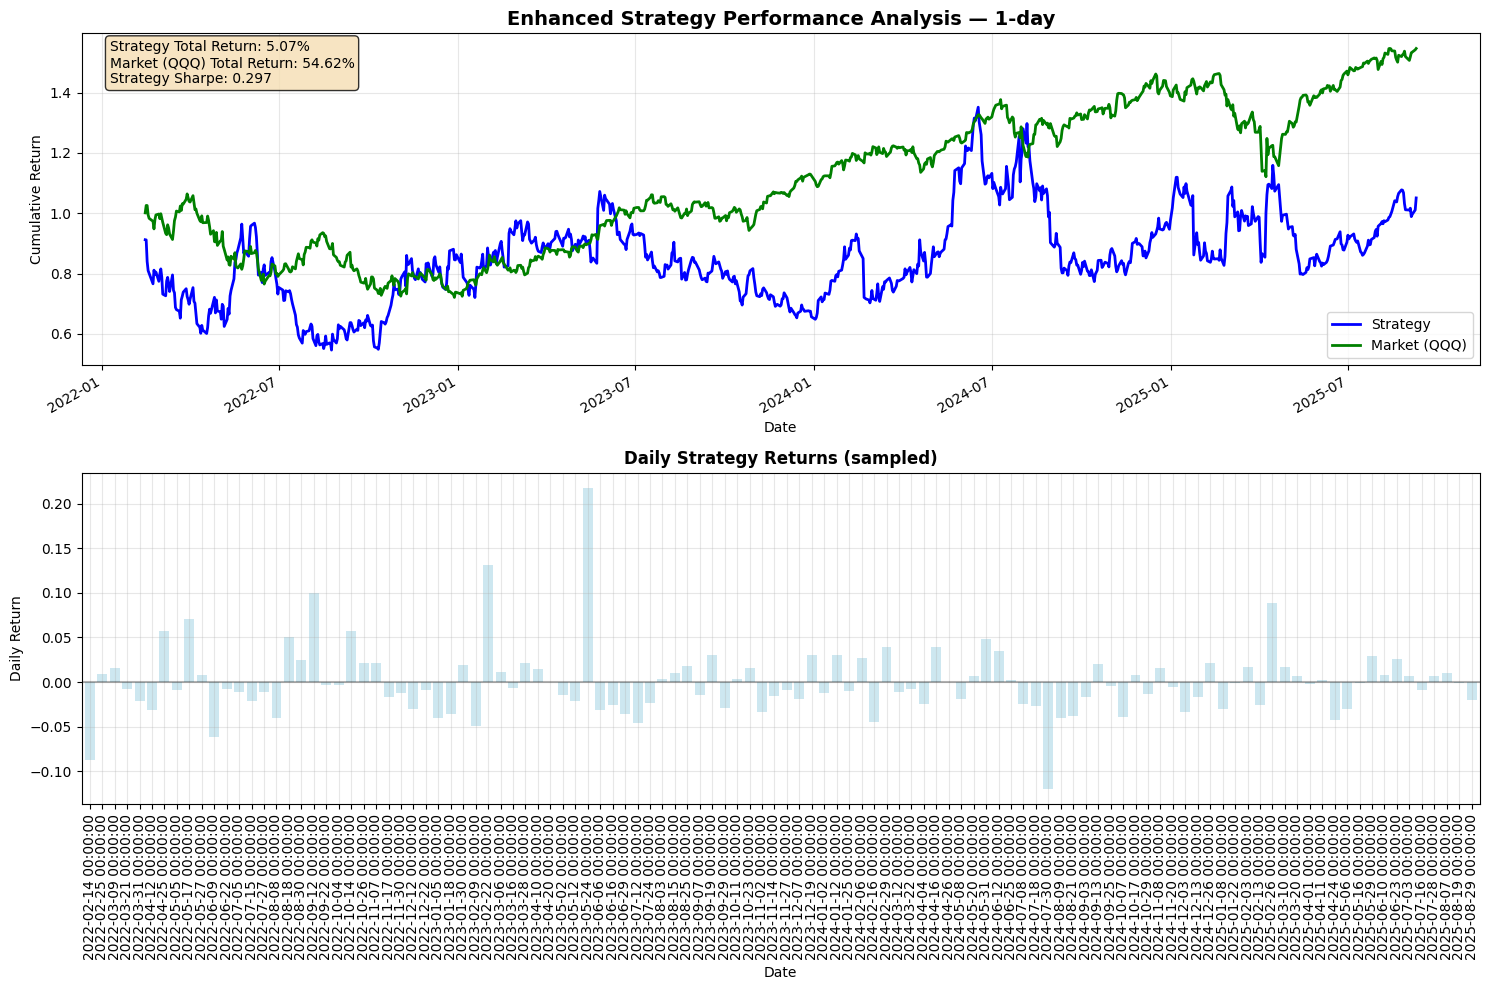

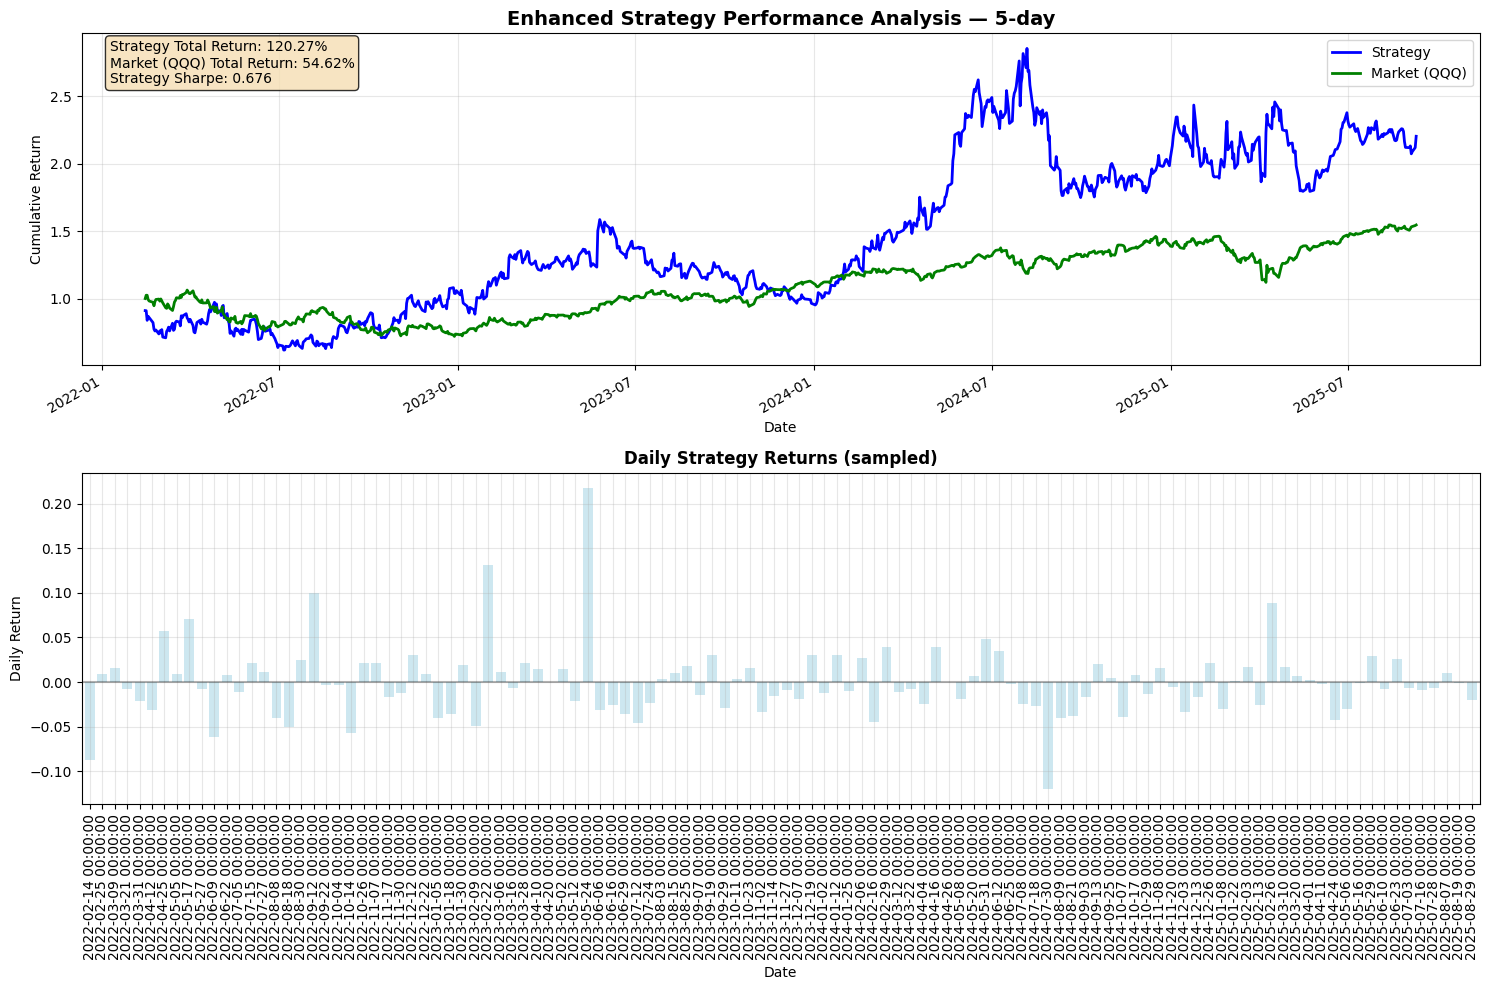

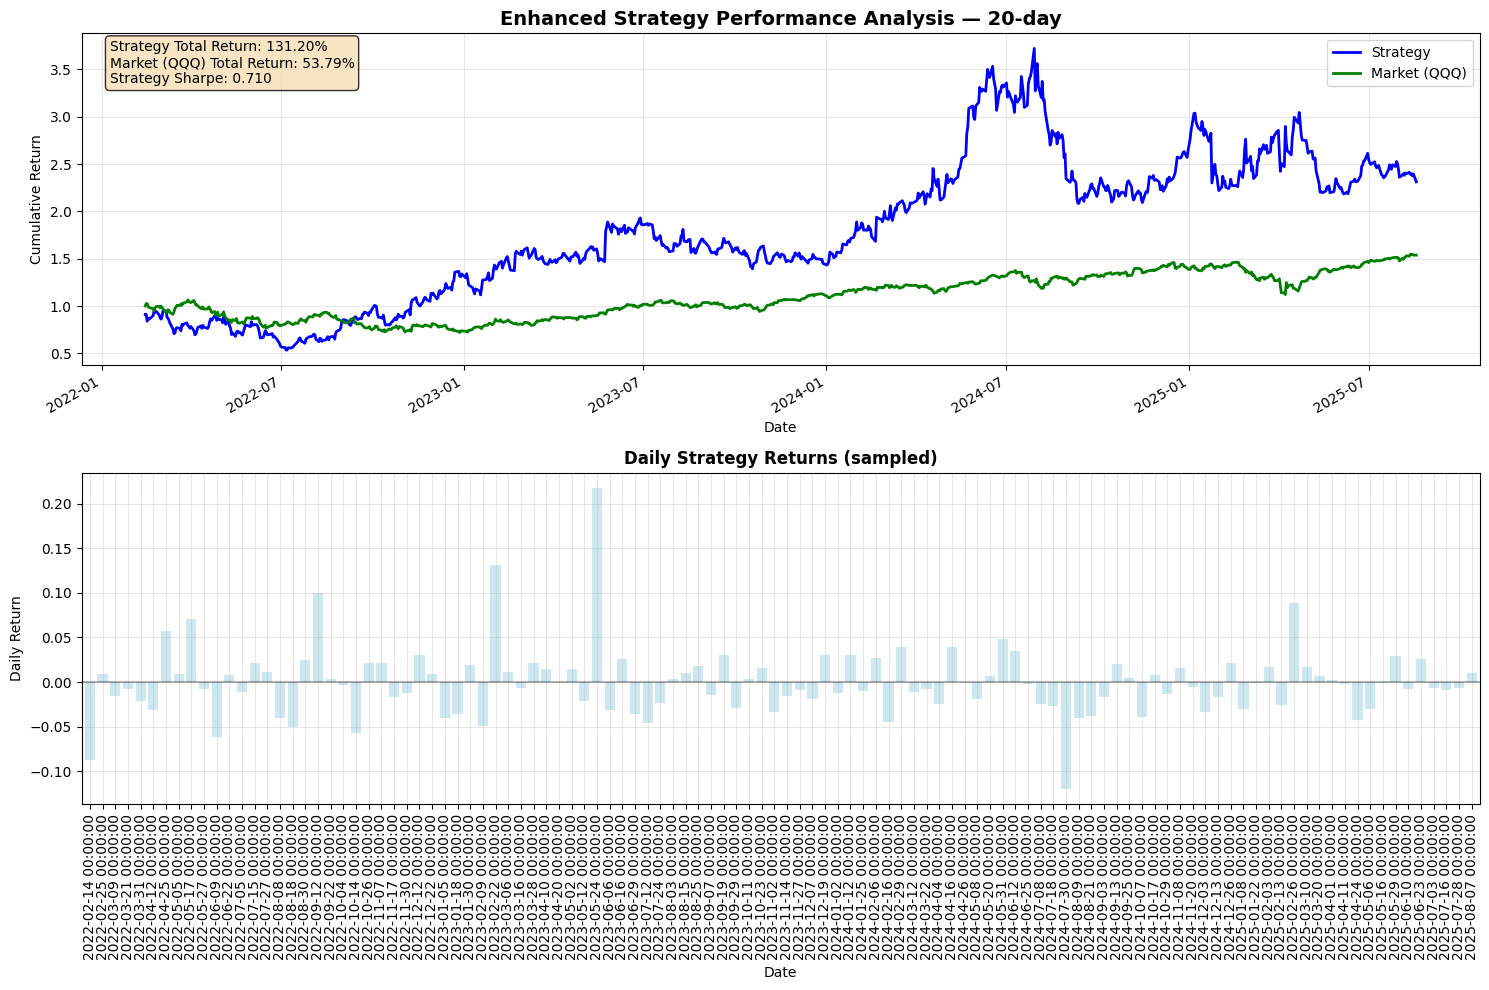


Residual diagnostics (1-day):  {'mean_residual': 0.002317, 'residual_std': 0.0346, 'residual_skew': 0.219695, 'residual_kurt': 3.682134, 'ljung_box_pval': 0.205579}

Residual diagnostics (5-day):  {'mean_residual': 0.002302, 'residual_std': 0.034519, 'residual_skew': 0.244263, 'residual_kurt': 3.672809, 'ljung_box_pval': 0.127438}
Residual diagnostics (20-day): {'mean_residual': 0.00235, 'residual_std': 0.034765, 'residual_skew': 0.219906, 'residual_kurt': 3.659083, 'ljung_box_pval': 0.118815}

Saved caches:
 1-day → artifacts\NVDA\20250910-214420_1-day
 5-day → artifacts\NVDA\20250910-214420_5-day
 20-day → artifacts\NVDA\20250910-214420_20-day


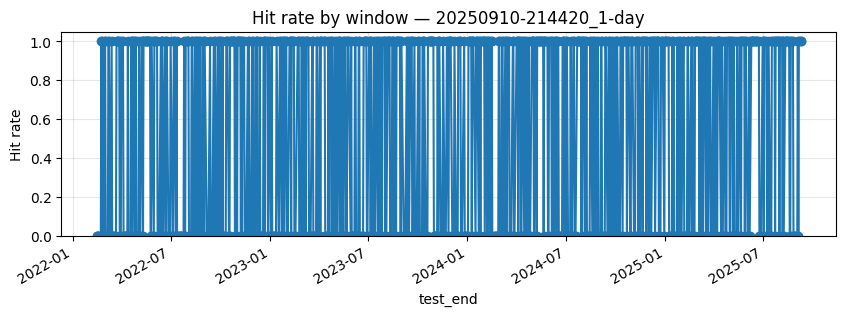

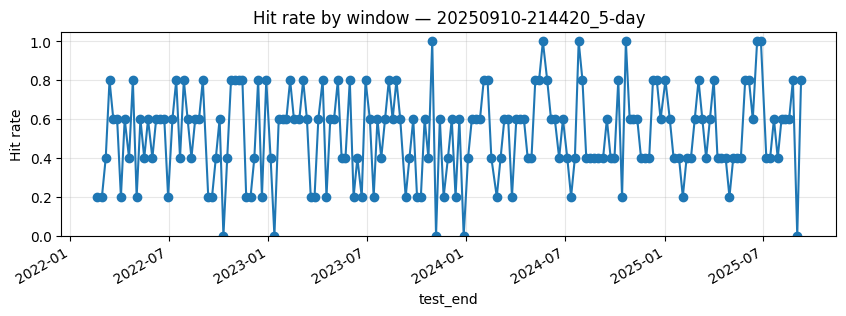

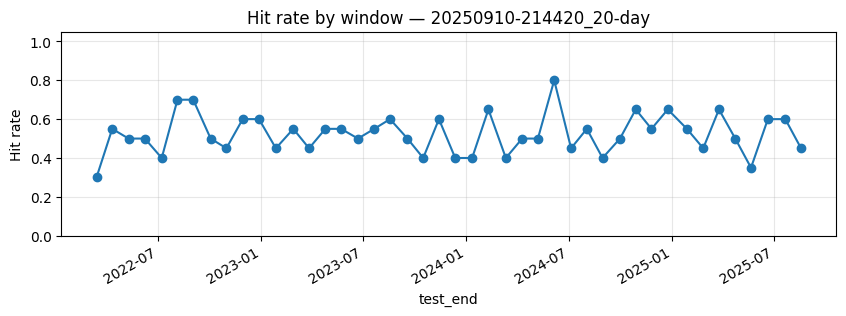

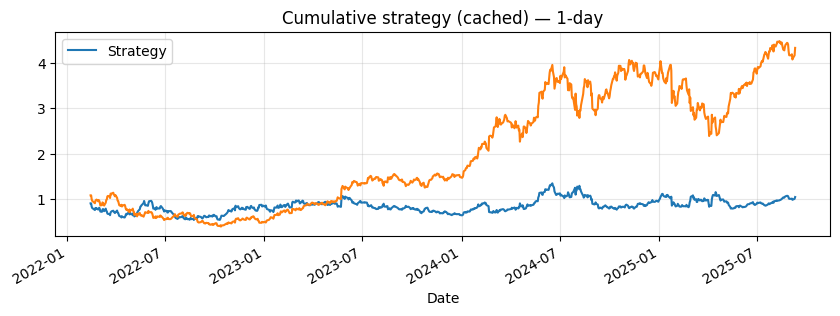

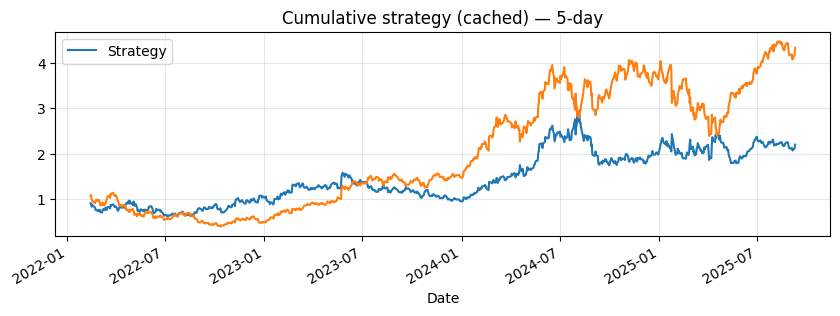

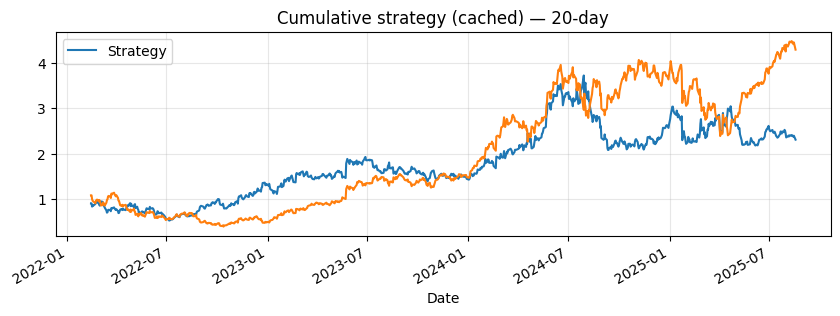

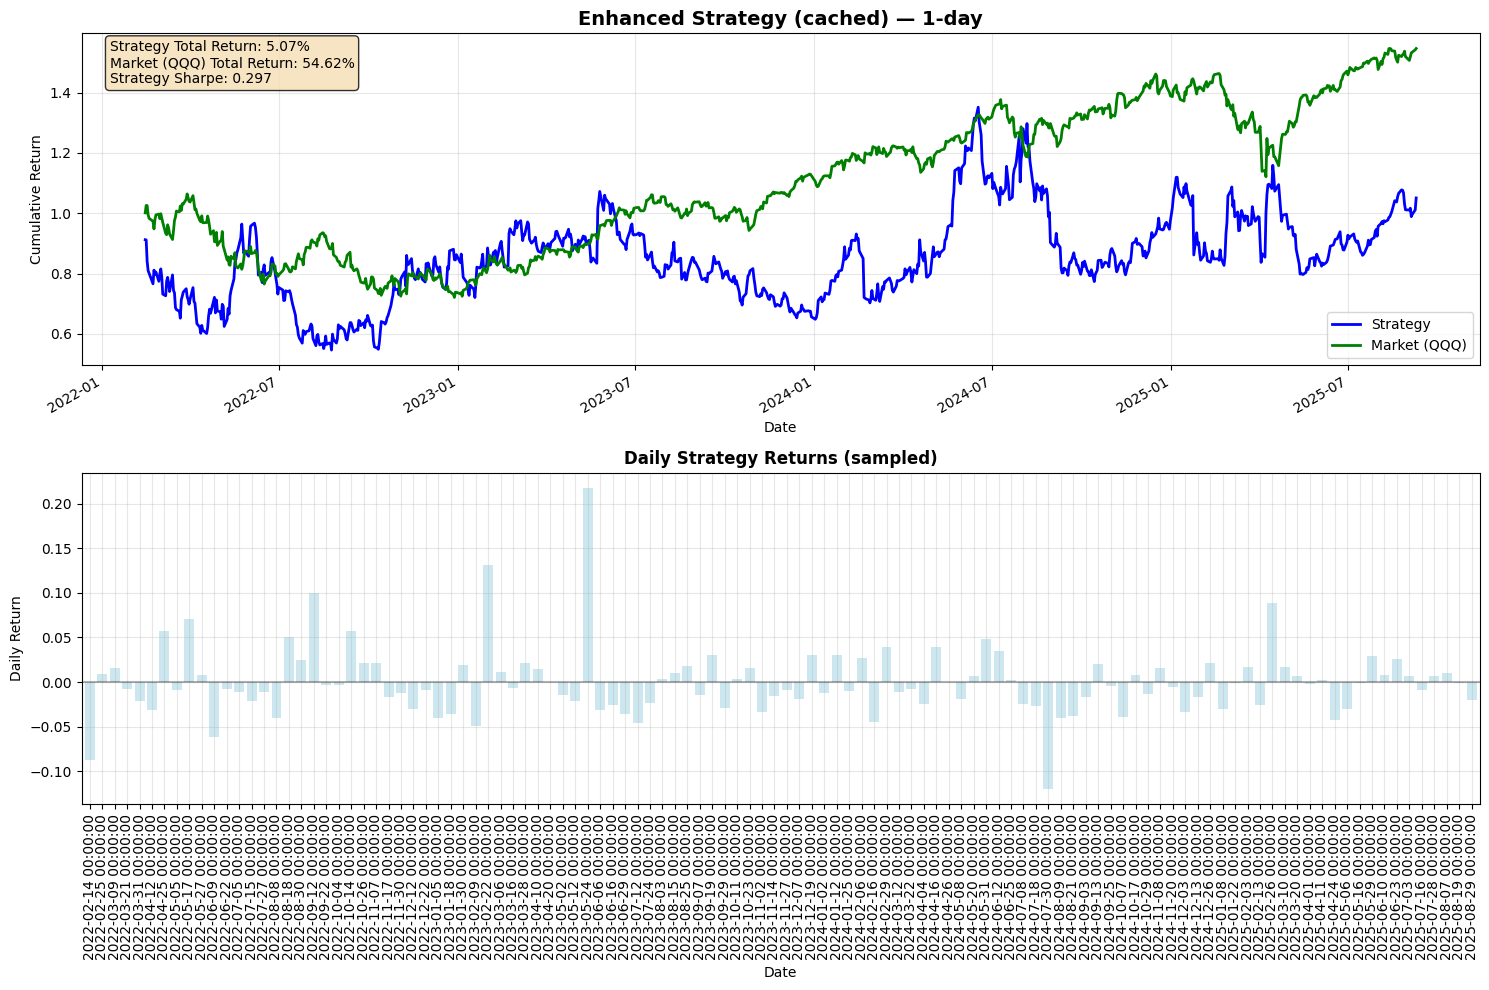

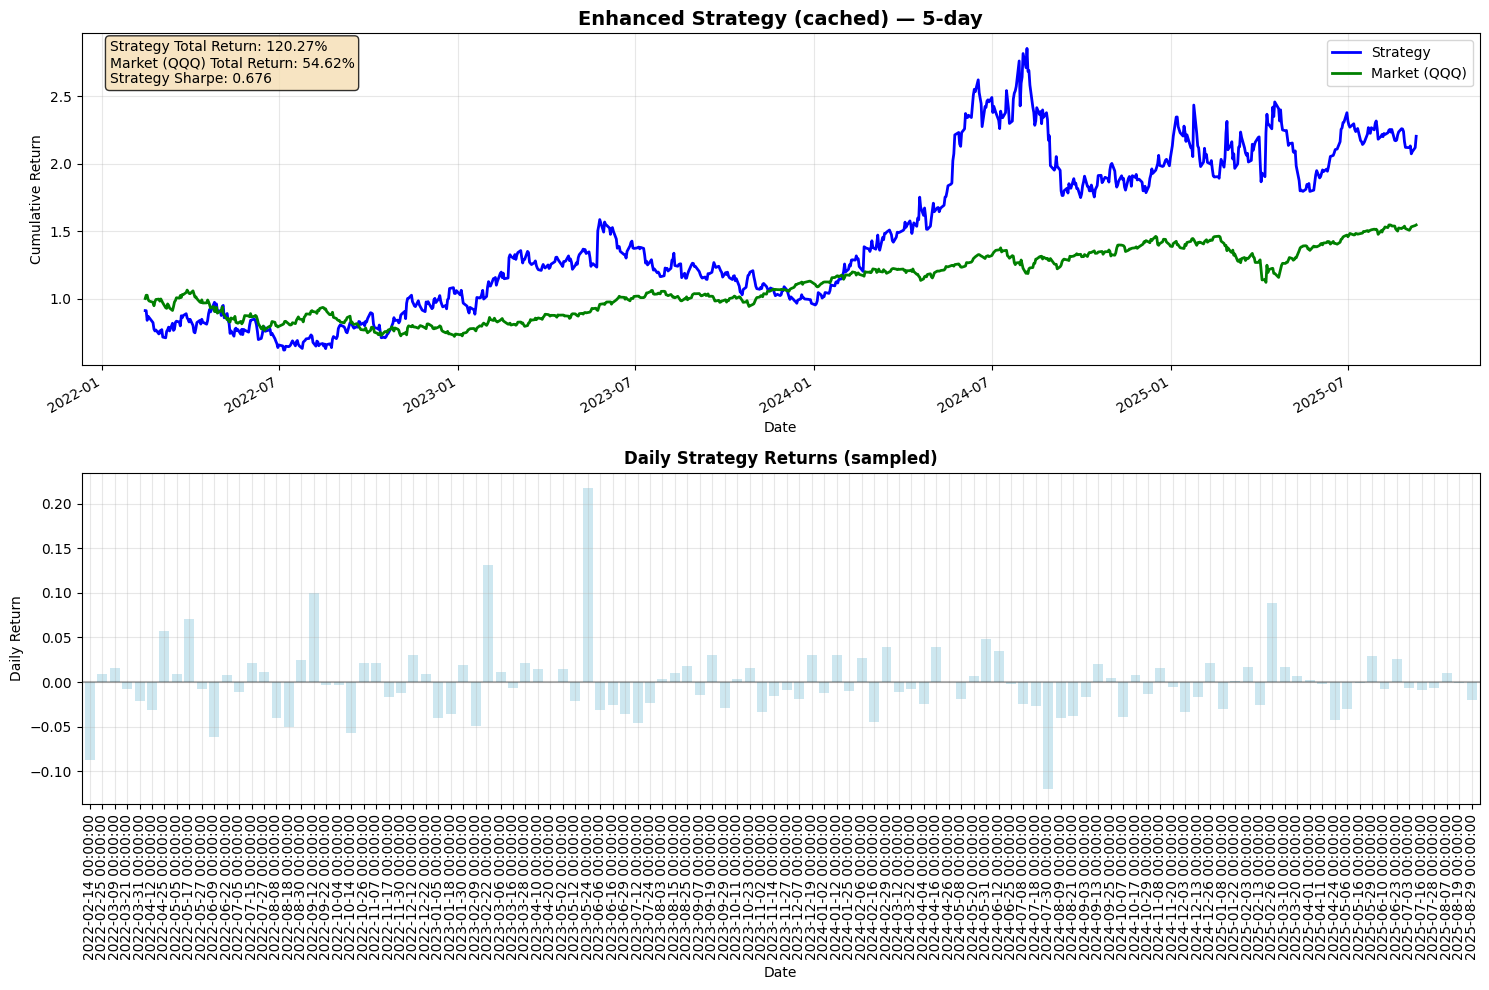

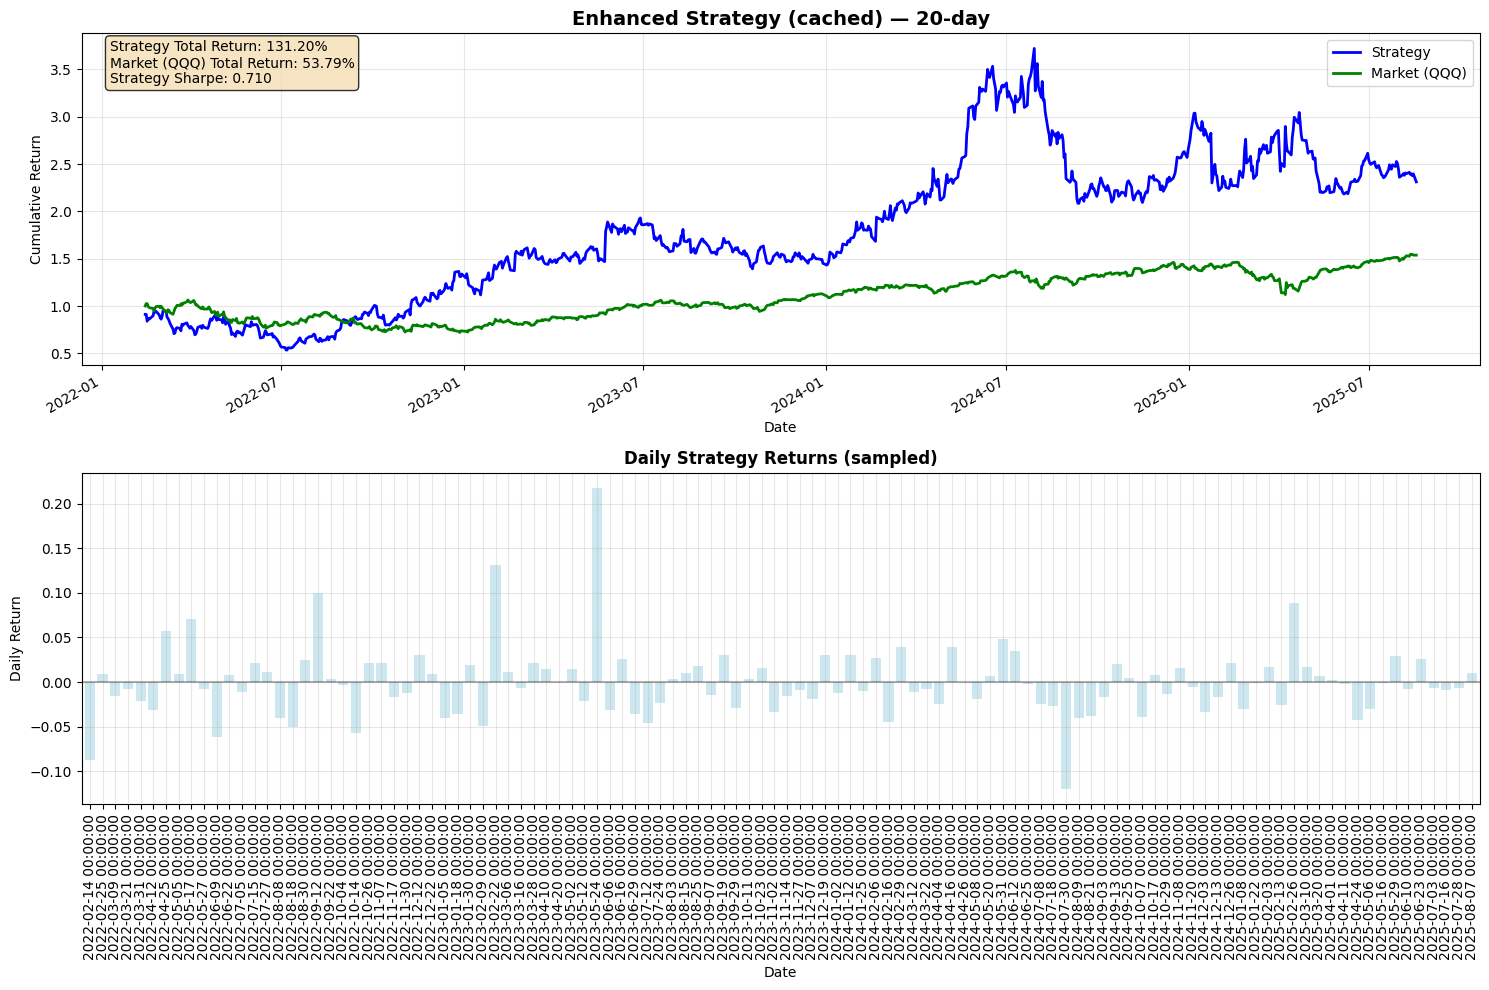

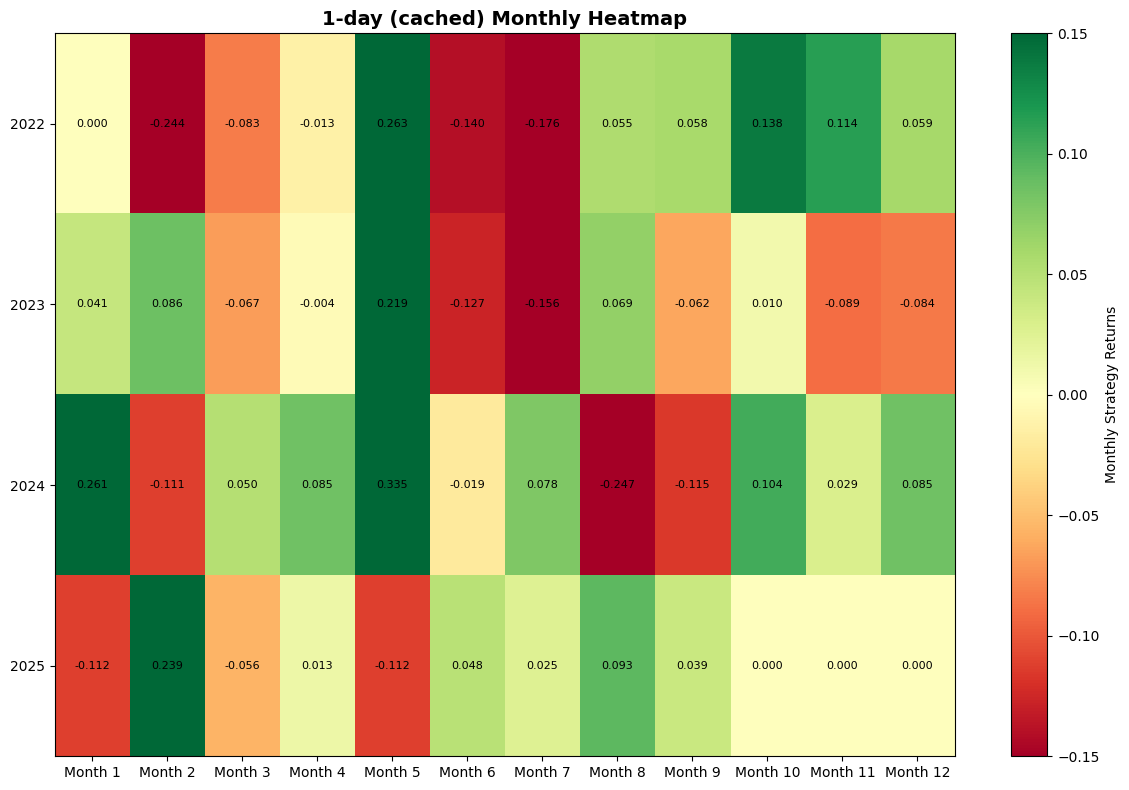

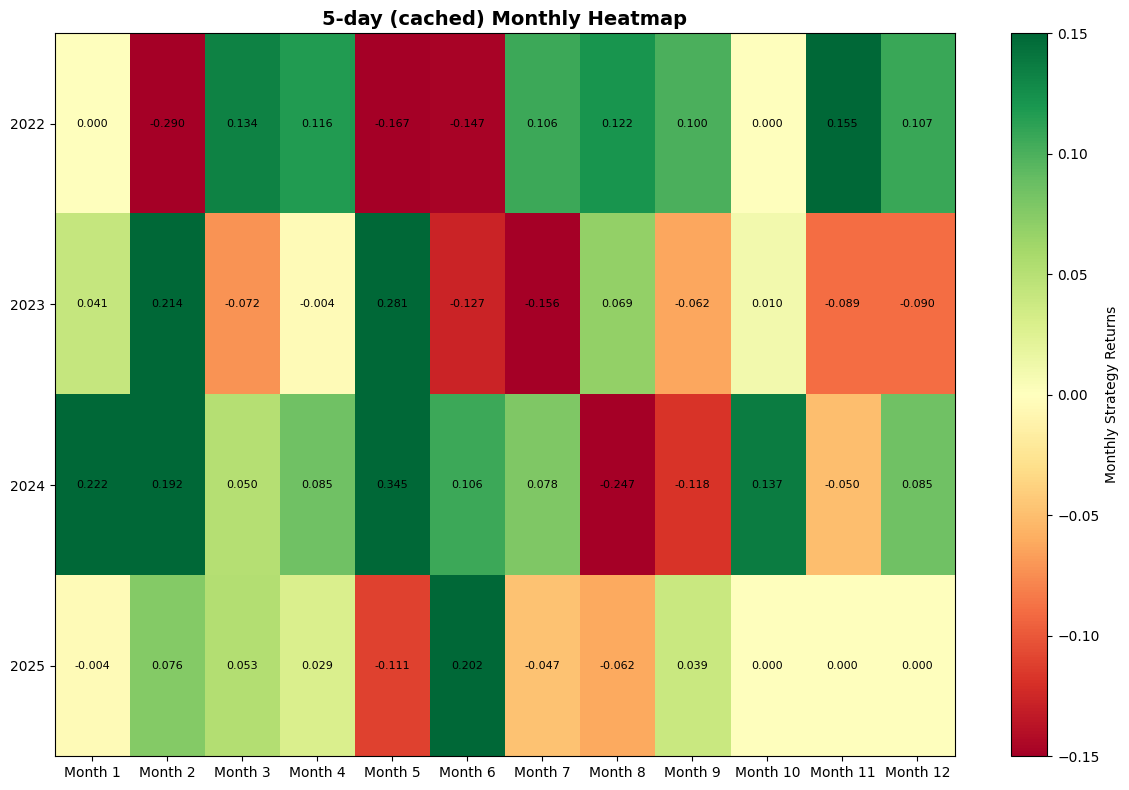

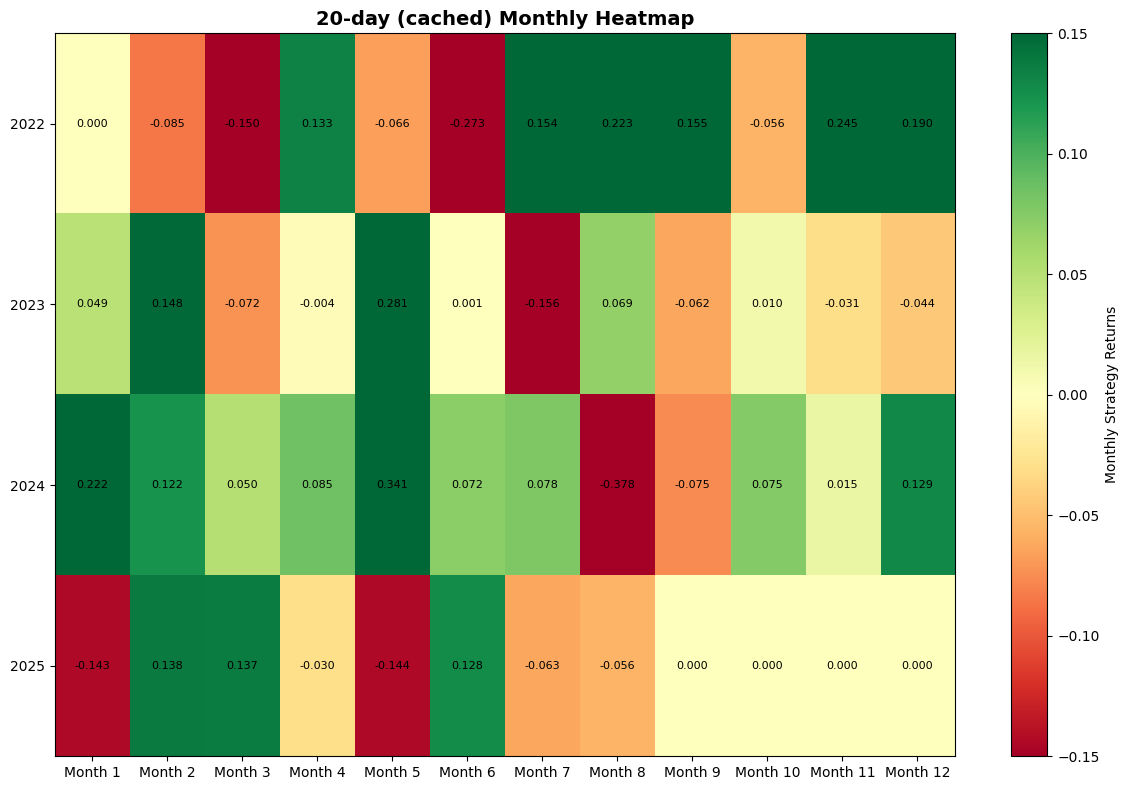

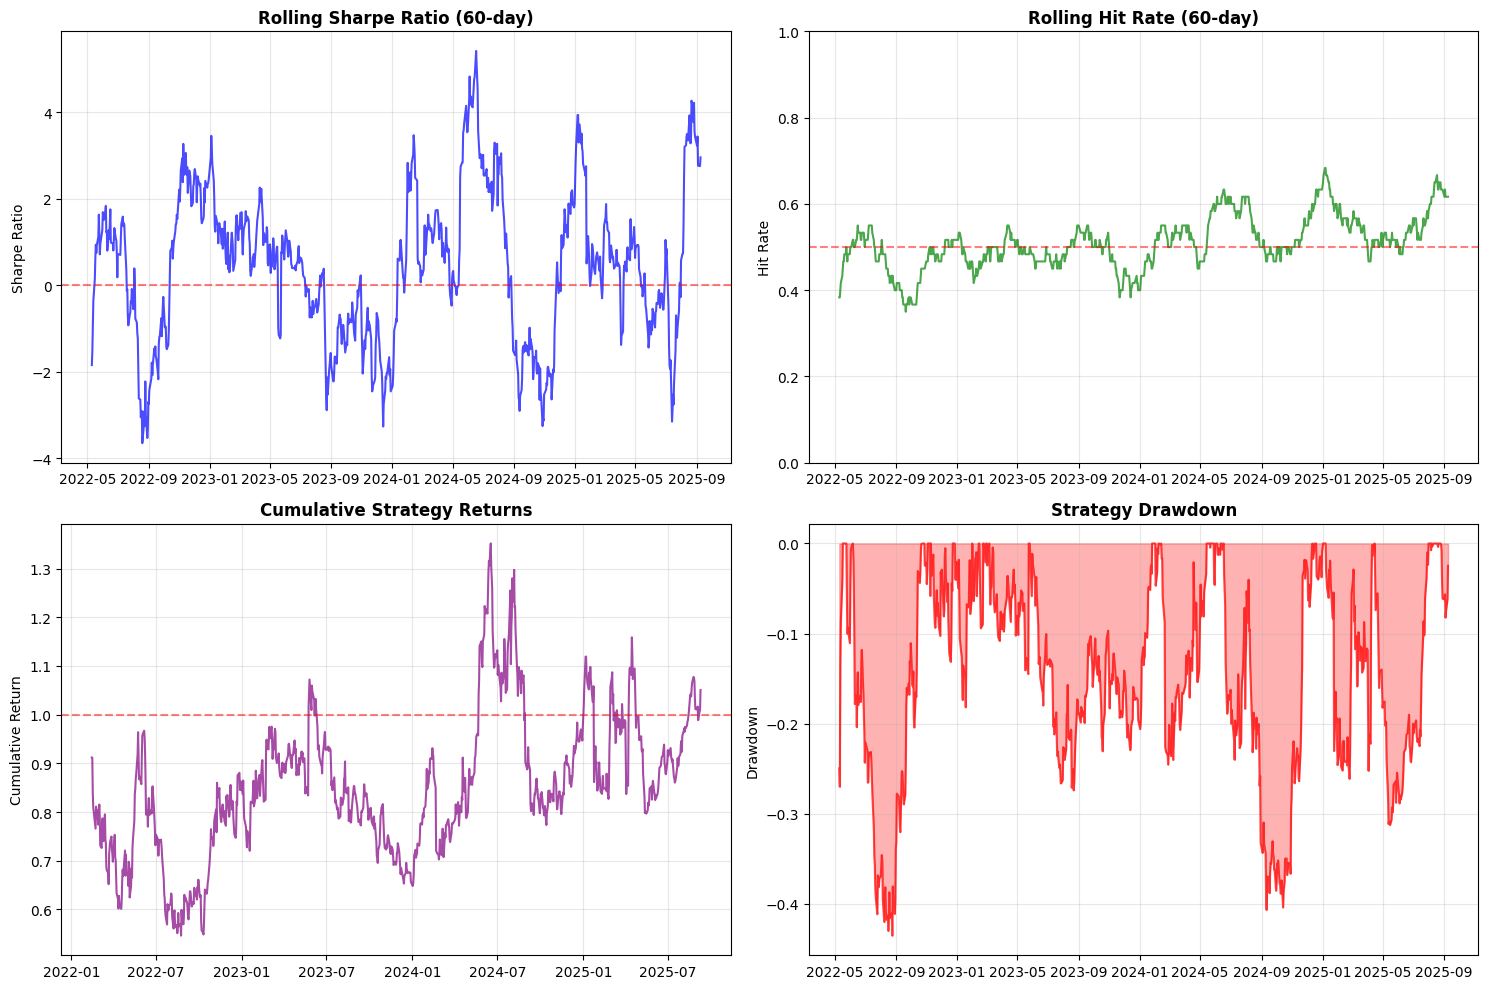

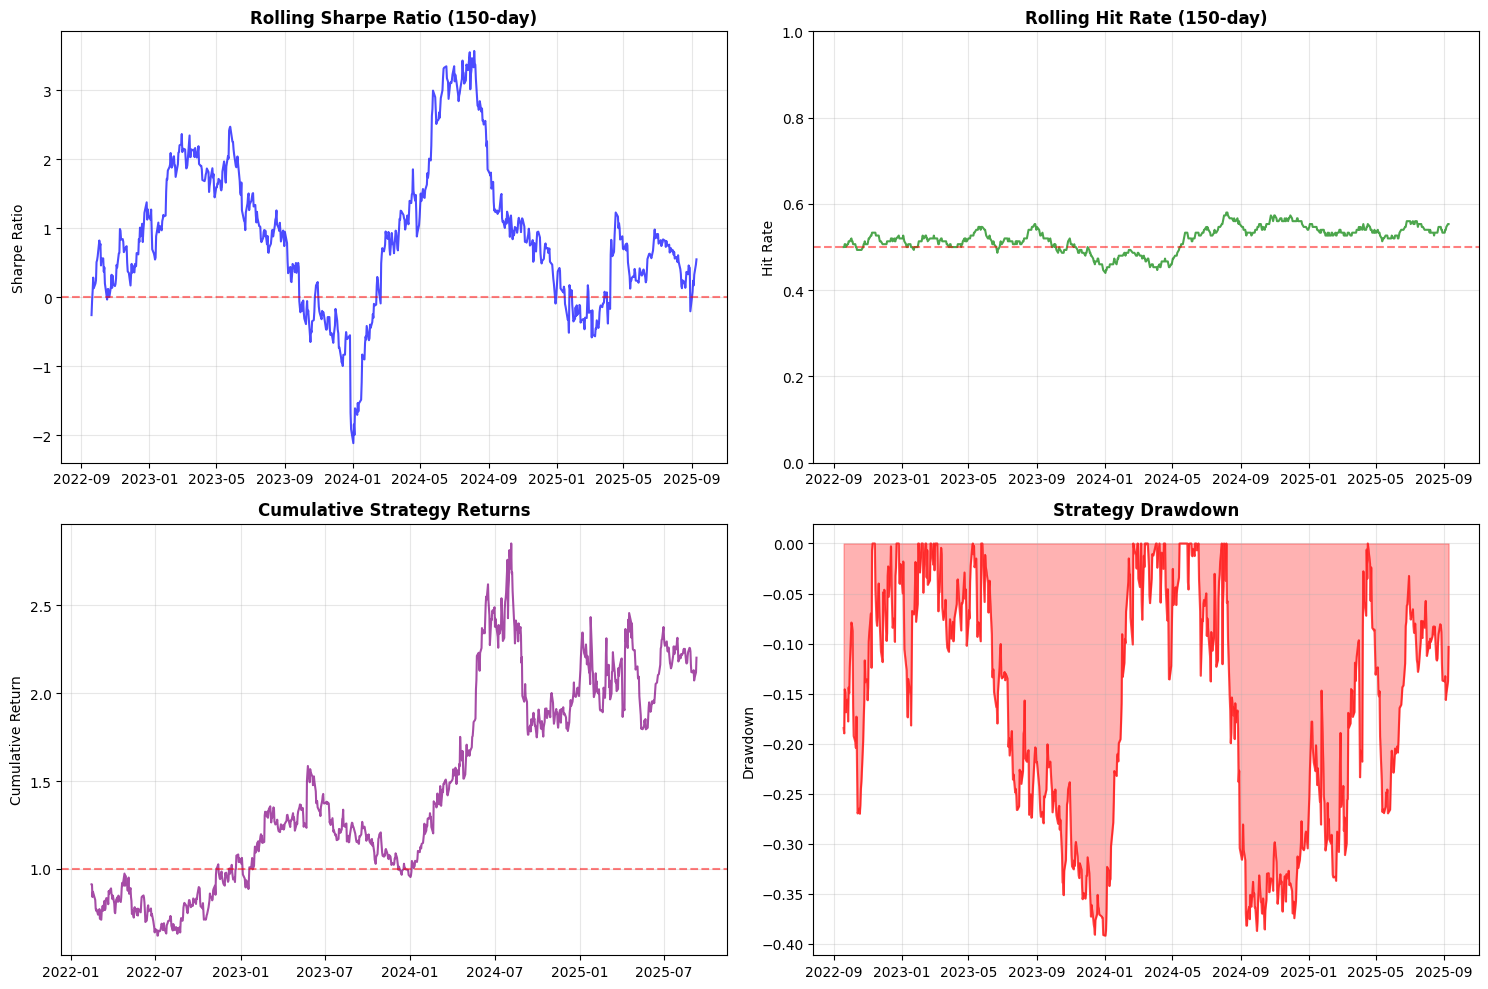

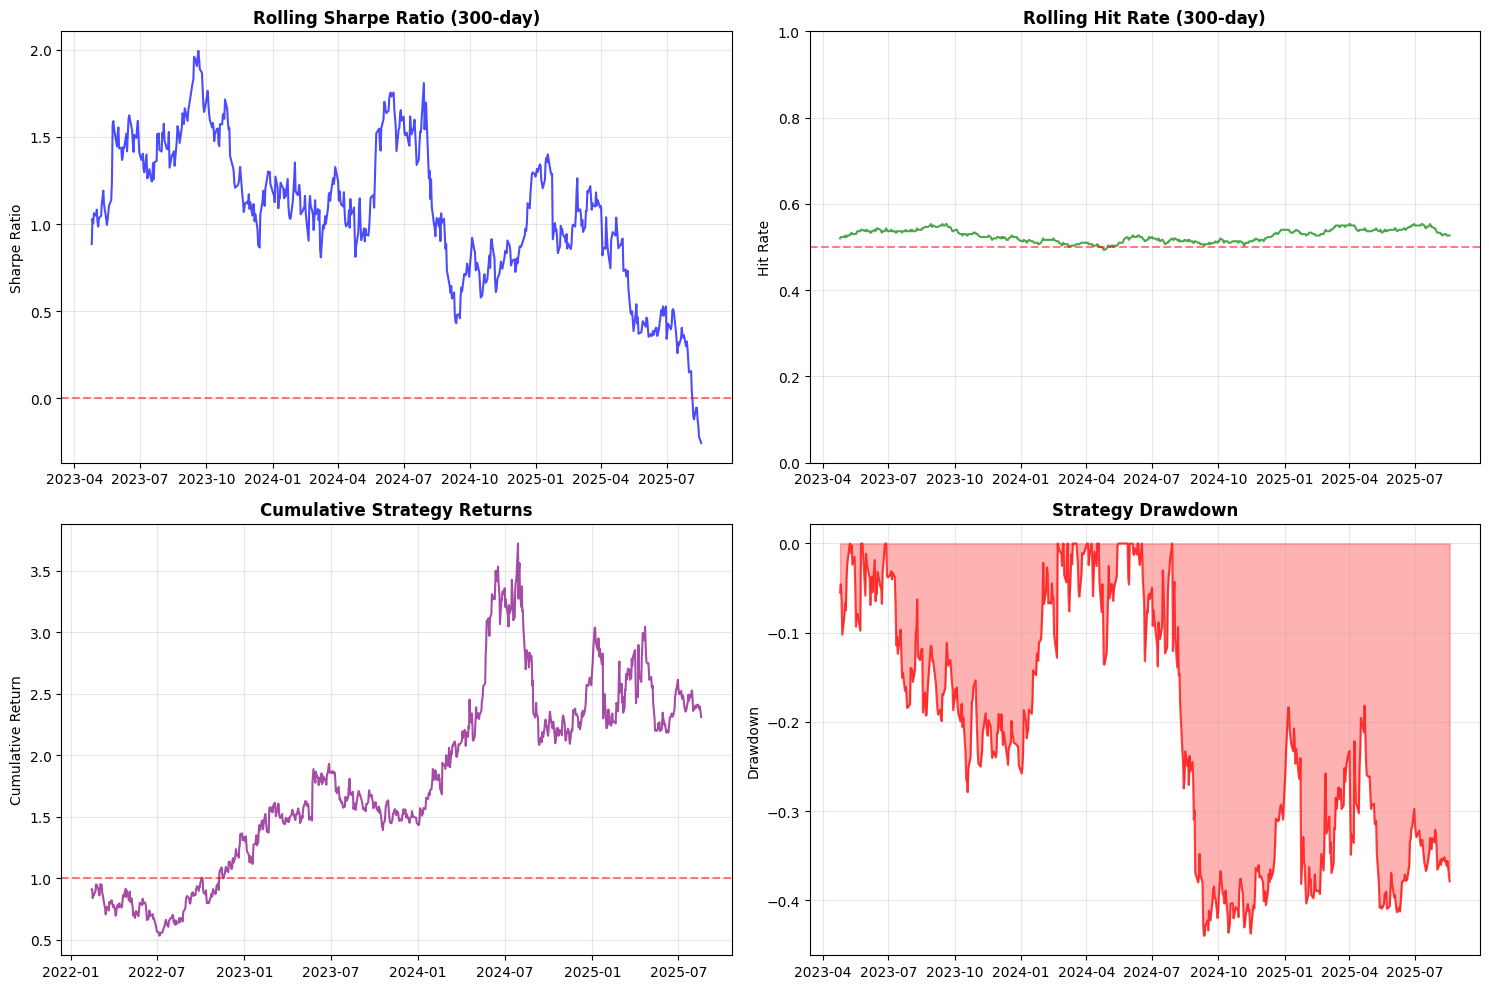

In [17]:

ASSET   = "NVDA"
MARKET  = "QQQ"
START   = "2020-01-01"
END     = "2025-12-31"

TRAIN_LEN = 504                 
ORDER_GRID = ((1,0,0),(0,0,1),(1,0,1),(2,0,1),(2,0,2))
EXOG_SETS = [
    ["mkt_ret_l1", "macd_hist_l1"],
    ["mkt_ret_l1","macd_hist_l1","macd_hist_l2","vol_z_l1"]
]
TARGET    = "y_next"
SCALERS   = ("zscore", "robust")

CFG1  = {"name": "1-day",  "test_len": 1,  "step": 1}
CFG5  = {"name": "5-day",  "test_len": 5,  "step": 5}
CFG20 = {"name": "20-day", "test_len": 20, "step": 20}

# Cache settings 
CACHE_DIR    = Path("artifacts") / ASSET
SAVE_FMT     = "parquet"   
SAVE_RESULTS = True        




# Helper: save & load a run

def _dump_json(path, obj):
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)

def save_run(run_dict, outdir, fmt="parquet", meta=None):
    """
    Persist a run produced by run_cfg.
    Saves: per_point, per_window, metrics.json, meta.json
    """
    out = Path(outdir)
    out.mkdir(parents=True, exist_ok=True)

    # DataFrames
    if fmt == "parquet":
        run_dict["per_point"].to_parquet(out / "per_point.parquet")
        run_dict["per_window"].to_parquet(out / "per_window.parquet")
    elif fmt == "csv":
        run_dict["per_point"].to_csv(out / "per_point.csv")
        run_dict["per_window"].to_csv(out / "per_window.csv")
    else:
        raise ValueError("fmt must be 'parquet' or 'csv'")

    # Metrics
    overall = run_dict.get("overall", {})
    if hasattr(overall, "__dict__"):
        metrics = {k: (float(v) if isinstance(v, (int, float)) else v)
                   for k, v in overall.__dict__.items()}
    elif isinstance(overall, dict):
        metrics = overall
    else:
        metrics = {}
    _dump_json(out / "metrics.json", metrics)

    # Meta
    _dump_json(out / "meta.json", meta or {})

def load_run(indir, fmt="parquet"):
    """
    Reload a saved run and return a dict that mirrors run_cfg output
    enough to work with your existing plotting functions.
    """
    p = Path(indir)
    if fmt == "parquet":
        per_point  = pd.read_parquet(p / "per_point.parquet")
        per_window = pd.read_parquet(p / "per_window.parquet")
    else:
        per_point  = pd.read_csv(p / "per_point.csv", index_col=0, parse_dates=True)
        per_window = pd.read_csv(p / "per_window.csv", index_col=0, parse_dates=True)

    try:
        with open(p / "metrics.json") as f:
            metrics = json.load(f)
    except FileNotFoundError:
        metrics = {}

    return {
        "per_point":  per_point,
        "per_window": per_window,
        "overall":    SimpleNamespace(**metrics),
        "name":       p.name
    }




def main():
    
    asset = load_prices(ASSET, start=START, end=END)
    mkt   = load_prices(MARKET, start=START, end=END, columns=("Close",))

    
    features = build_features(
        stock_close=asset["Close"],
        stock_volume=asset["Volume"],
        market_close=mkt["Close"],
        include_eoq=True,
        macd="hist",
    )

    
    features = add_lags(features, cols=["mkt_ret","vol_z","macd_hist"], lags=(1,2))

    
    supervised = make_nextday_target(features, target_col="ret", out_col=TARGET)

    
    grid_results = []
    for exogs in EXOG_SETS:
        for sc in SCALERS:
            grid_results.append(
                run_cfg(
                    supervised,
                    CFG1,
                    scaler=sc,
                    exogs=exogs,
                    name_suffix=f"+{','.join(exogs)}"
                )
            )

    top1 = sorted(grid_results, key=lambda r: r["overall"].rmse)[:3]
    print("=== CFG1 (1-day) — Top by RMSE ===")
    for r in top1:
        m = r["overall"]
        print(f"{r['name']}: RMSE={m.rmse:.6f}  MAE={m.mae:.6f}  Hit={m.hit_rate:.3f}  Windows={m.n_windows}")

    
    best1 = top1[0]
    plot_hitrate_timeline(best1); plt.show()
    plot_cum_pnl(best1["per_point"], f"Cumulative strategy vs Buy&Hold — {best1['name']}")

    
    res1  = run_cfg(supervised, CFG1)
    res5  = run_cfg(supervised, CFG5)
    res20 = run_cfg(supervised, CFG20)

    
    print_overall_metrics([res1, res5, res20])

    
    plot_hitrate_timeline(res1);  plt.show()
    plot_hitrate_timeline(res5);  plt.show()
    plot_hitrate_timeline(res20); plt.show()

    plot_cum_pnl(res1["per_point"],  "Cumulative strategy vs Buy&Hold - 1-day folds")
    plot_cum_pnl(res5["per_point"],  "Cumulative strategy vs Buy&Hold — 5-day folds")
    plot_cum_pnl(res20["per_point"], "Cumulative strategy vs Buy&Hold — 20-day folds")

    
    market_features = build_features(
        stock_close=mkt["Close"],
        stock_volume=pd.Series([1]*len(mkt), index=mkt.index),  
        market_close=None,
        include_eoq=False,
        macd="none",
    )
    if SAVE_RESULTS:
        CACHE_DIR.mkdir(parents=True, exist_ok=True)
        (CACHE_DIR / "market_ret.parquet").write_bytes(
            market_features["ret"].to_frame("ret").to_parquet()
            if SAVE_FMT == "parquet"
            else market_features["ret"].to_frame("ret").to_csv().encode()
        )

    plot_detailed_strategy_window(res1["per_point"], market_data=market_features,
                                  title="Daily returns inside the window - 1-day strategy", max_days=30)
    plot_detailed_strategy_window(res5["per_point"], market_data=market_features,
                                  title="Daily returns inside the window - 5-day strategy", max_days=150)
    plot_detailed_strategy_window(res20["per_point"], market_data=market_features,
                                  title="Daily returns inside the window - 20-day strategy", max_days=300)

    plot_strategy_heatmap(res1["per_point"], "1-day Strategy Monthly Performance Heatmap")
    plot_strategy_heatmap(res5["per_point"], "5-day Strategy Performance Heatmap")
    plot_strategy_heatmap(res20["per_point"], "20-day Strategy Performance Heatmap")

    plot_rolling_performance_metrics(res1["per_point"],  window=60,  title="Rolling Performance Metrics (60-day)")
    plot_rolling_performance_metrics(res5["per_point"],  window=150, title="Rolling Performance Metrics (150-day)")
    plot_rolling_performance_metrics(res20["per_point"], window=300, title="Rolling Performance Metrics (300-day)")

    enhanced_plot_cum_pnl(res1["per_point"],  market_ret_series=market_features["ret"],
                          title="Enhanced Strategy Performance Analysis — 1-day")
    enhanced_plot_cum_pnl(res5["per_point"],  market_ret_series=market_features["ret"],
                          title="Enhanced Strategy Performance Analysis — 5-day")
    enhanced_plot_cum_pnl(res20["per_point"], market_ret_series=market_features["ret"],
                          title="Enhanced Strategy Performance Analysis — 20-day")

    
    res_stats_1  = analyze_residuals(res1["per_point"])
    res_stats_5  = analyze_residuals(res5["per_point"])
    res_stats_20 = analyze_residuals(res20["per_point"])
    print("\nResidual diagnostics (1-day): ",  {k: round(v, 6) if isinstance(v, float) else v for k, v in res_stats_1.items()})
    print("\nResidual diagnostics (5-day): ",  {k: round(v, 6) if isinstance(v, float) else v for k, v in res_stats_5.items()})
    print("Residual diagnostics (20-day):",    {k: round(v, 6) if isinstance(v, float) else v for k, v in res_stats_20.items()})


    if SAVE_RESULTS:
        stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
        out1  = CACHE_DIR / f"{stamp}_{CFG1['name']}"
        out5  = CACHE_DIR / f"{stamp}_{CFG5['name']}"
        out20 = CACHE_DIR / f"{stamp}_{CFG20['name']}"

        save_run(res1,  out1,  fmt=SAVE_FMT, meta={"asset": ASSET, "cfg": CFG1,  "start": START, "end": END})
        save_run(res5,  out5,  fmt=SAVE_FMT, meta={"asset": ASSET, "cfg": CFG5,  "start": START, "end": END})
        save_run(res20, out20, fmt=SAVE_FMT, meta={"asset": ASSET, "cfg": CFG20, "start": START, "end": END})

        
        _dump_json(CACHE_DIR / "latest.json", {"cfg1": str(out1), "cfg5": str(out5), "cfg20": str(out20)})
        print(f"\nSaved caches:\n 1-day → {out1}\n 5-day → {out5}\n 20-day → {out20}")

    try:
        with open(CACHE_DIR / "latest.json") as f:
            latest = json.load(f)
        r1_cached  = load_run(latest["cfg1"],  fmt=SAVE_FMT)
        r5_cached  = load_run(latest["cfg5"],  fmt=SAVE_FMT)
        r20_cached = load_run(latest["cfg20"], fmt=SAVE_FMT)

        # Market returns for enhanced plot
        mkt_ret_path = CACHE_DIR / "market_ret.parquet"
        if mkt_ret_path.exists():
            mkt_ret = pd.read_parquet(mkt_ret_path)["ret"]
        else:
            mkt_ret = None  

        # Plug cached results straight into my plotters
        plot_hitrate_timeline(r1_cached);  plt.show()
        plot_hitrate_timeline(r5_cached);  plt.show()
        plot_hitrate_timeline(r20_cached); plt.show()

        plot_cum_pnl(r1_cached["per_point"],  "Cumulative strategy (cached) — 1-day")
        plot_cum_pnl(r5_cached["per_point"],  "Cumulative strategy (cached) — 5-day")
        plot_cum_pnl(r20_cached["per_point"], "Cumulative strategy (cached) — 20-day")

        enhanced_plot_cum_pnl(r1_cached["per_point"],  market_ret_series=mkt_ret,
                              title="Enhanced Strategy (cached) — 1-day")
        enhanced_plot_cum_pnl(r5_cached["per_point"],  market_ret_series=mkt_ret,
                              title="Enhanced Strategy (cached) — 5-day")
        enhanced_plot_cum_pnl(r20_cached["per_point"], market_ret_series=mkt_ret,
                              title="Enhanced Strategy (cached) — 20-day")

        plot_strategy_heatmap(r1_cached["per_point"],  "1-day (cached) Monthly Heatmap")
        plot_strategy_heatmap(r5_cached["per_point"],  "5-day (cached) Monthly Heatmap")
        plot_strategy_heatmap(r20_cached["per_point"], "20-day (cached) Monthly Heatmap")

        plot_rolling_performance_metrics(r1_cached["per_point"],  window=60,  title="Rolling (cached) — 60d")
        plot_rolling_performance_metrics(r5_cached["per_point"],  window=150, title="Rolling (cached) — 150d")
        plot_rolling_performance_metrics(r20_cached["per_point"], window=300, title="Rolling (cached) — 300d")

    except FileNotFoundError:
        pass


if __name__ == "__main__":
    main()
